# Forecasting Global Commercial Flight Volumes
The object of this project is to predict global flight volumes using the data from [Flightradar24](https://www.flightradar24.com/). This site tracks aviation data. I obtained the dataset by navigating to "Aviation Data", then "Flight tracking statistics", and selecting "Number of commercial flights tracked by Flightradar24, per day (UTC time)". I downloaded the data as the file "total-number-of-flights.csv".

First, let's try the Gradient Boosting Regressor to see what sort of results we can get.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

df = pd.read_csv('total-number-of-flights.csv')

# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d')

# Create a list of features
features = ['2024 7-day moving average', '2023 7-day moving average', '2022 7-day moving average',
            '2021 7-day moving average', '2020 7-day moving average']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['2024 Number of flights'], test_size=0.2, random_state=42)

# Combine X and y into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Remove rows with missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Separate X and y after removing missing values
X_train = train_data[features]
y_train = train_data['2024 Number of flights']
X_test = test_data[features]
y_test = test_data['2024 Number of flights']

# Interpolate missing values in the feature data
X_train = X_train.interpolate()
X_test = X_test.interpolate()

# Create and train the model
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 18371.799364641523


In [10]:
import numpy as np
from sklearn.utils import resample

# Define the number of bootstrap samples
n_bootstraps = 1000

# Initialize arrays to store bootstrap predictions
bootstrap_predictions = np.zeros((n_bootstraps, len(y_test)))

# Perform bootstrapping
for i in range(n_bootstraps):
    # Resample the training data with replacement
    indices = resample(range(len(X_train)), replace=True, n_samples=len(X_train))
    X_train_bootstrap = X_train.iloc[indices]
    y_train_bootstrap = y_train.iloc[indices]

    # Fit the model on the bootstrapped data
    model.fit(X_train_bootstrap, y_train_bootstrap)

    # Make predictions on the test set
    bootstrap_predictions[i] = model.predict(X_test)

# Calculate the prediction intervals
prediction_intervals = np.percentile(bootstrap_predictions, [5, 25, 50, 75, 95], axis=0)

# Print the prediction intervals
for i, level in enumerate([5, 25, 50, 75, 95]):
    print(f'{level}% Prediction Interval: {prediction_intervals[i]}')

5% Prediction Interval: [171911.77340435 160984.34991484 195075.48225396 194556.36258067
 200324.04864245 213827.05039048 180827.56428168 188576.68391388
 174664.07441908 219289.97732204 163569.87769156 185973.38582351
 168591.61721805 202416.09734133 172029.93071468 205303.03337121
 180465.60874014 167492.2140199  170960.32084694 202384.45762241
 195717.83769351 187611.10731346 176181.42424191 181483.88025032
 199093.54333186 177713.54048413 192007.8746085  192126.14877613
 179829.10090883 186291.70591412 205834.89857458 190129.10311997
 185682.84166809]
25% Prediction Interval: [175459.0314366  168544.16876889 199623.40364192 198991.63142151
 206488.98523021 229074.05556246 185597.69017547 195983.41872951
 183237.74725519 221287.51381675 167927.2733202  194366.41660527
 171337.7720302  208521.33034303 180594.80280485 216980.1661379
 185551.6299123  170634.34087093 178115.78713412 207677.33989168
 202104.67041528 195571.00260433 185120.95527749 189556.74156495
 206227.64294107 187061.

In [20]:
# Impute missing values with the mean
last_row = df[features].iloc[-1:].fillna(df[features].mean())

# Create a DataFrame with the forecast date and feature values
forecast_date = pd.to_datetime('2024-05-31')
forecast_data = pd.DataFrame({'DateTime': [forecast_date]})
forecast_data = forecast_data.join(last_row.reset_index(drop=True), how='left')

# Make the forecast
forecast_value = model.predict(forecast_data[features])[0]
print(f'Forecasted number of flights on {forecast_date.date()}: {forecast_value}')

Forecasted number of flights on 2024-05-31: 183357.83603337148


This number looks low considering May 2024 has been trending around 220,000 commercial flights per day. Historic data shows a small increase in these flights throughout the month. So let's look at some confidence intervals based on the mean and median.

In [16]:
import numpy as np

# Convert the prediction intervals to a NumPy array
prediction_intervals = np.array(prediction_intervals)

# Calculate the mean of each prediction interval
mean_intervals = np.mean(prediction_intervals, axis=1)
print("Mean Prediction Intervals:")
print(f"5% Prediction Interval: {mean_intervals[0]:.2f}")
print(f"25% Prediction Interval: {mean_intervals[1]:.2f}")
print(f"50% Prediction Interval: {mean_intervals[2]:.2f}")
print(f"75% Prediction Interval: {mean_intervals[3]:.2f}")
print(f"95% Prediction Interval: {mean_intervals[4]:.2f}")

# Calculate the median of each prediction interval
median_intervals = np.median(prediction_intervals, axis=1)
print("\nMedian Prediction Intervals:")
print(f"5% Prediction Interval: {median_intervals[0]:.2f}")
print(f"25% Prediction Interval: {median_intervals[1]:.2f}")
print(f"50% Prediction Interval: {median_intervals[2]:.2f}")
print(f"75% Prediction Interval: {median_intervals[3]:.2f}")
print(f"95% Prediction Interval: {median_intervals[4]:.2f}")

Mean Prediction Intervals:
5% Prediction Interval: 186937.18
25% Prediction Interval: 193692.12
50% Prediction Interval: 199294.25
75% Prediction Interval: 205709.13
95% Prediction Interval: 213410.68

Median Prediction Intervals:
5% Prediction Interval: 186291.71
25% Prediction Interval: 195571.00
50% Prediction Interval: 200710.34
75% Prediction Interval: 205459.08
95% Prediction Interval: 213132.97


That looks a little closer to the expected prediction, but there are some more models to make and try. SARIMA can show us seasonal trends.

Last observed date: 2024-12-31
Found rows beyond May 9, 2024. Cleaning the data...
Updated last observed date: 2024-05-09
ADF Statistic: -0.269665
p-value: 0.929692


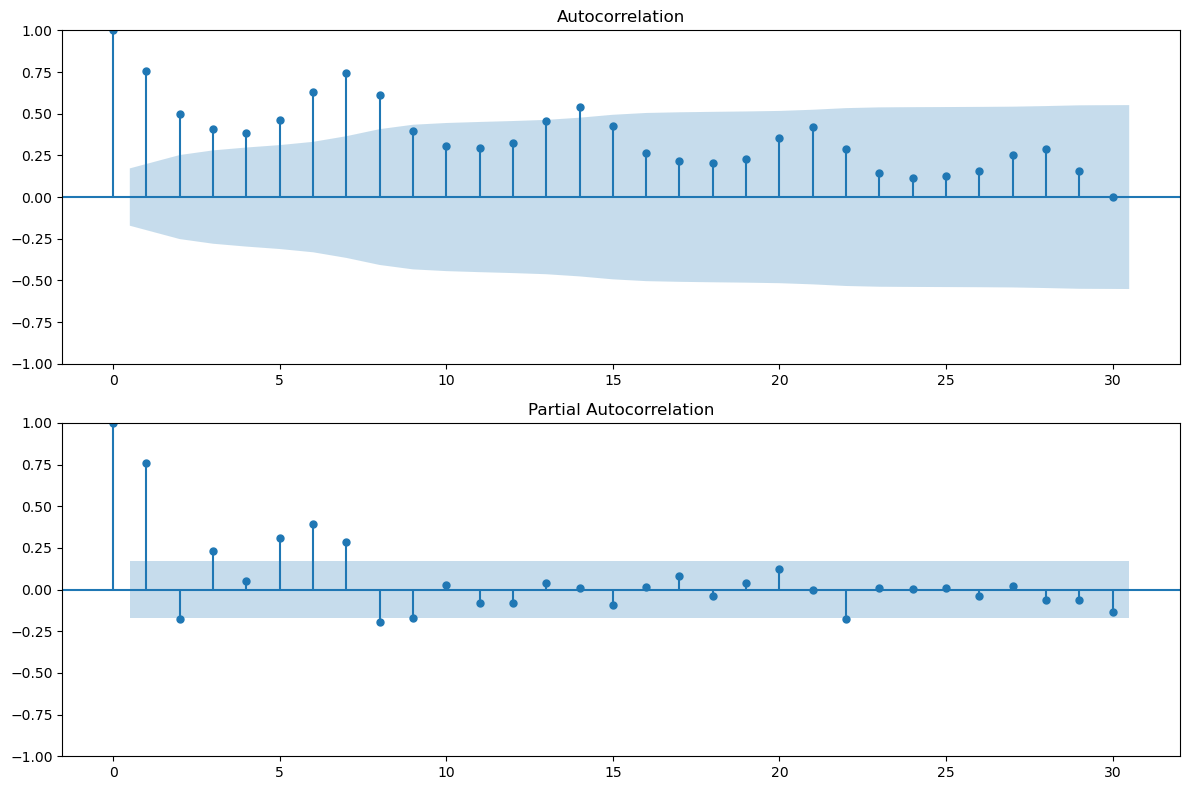

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01072D+01    |proj g|=  3.15955D-01

At iterate    5    f=  9.96031D+00    |proj g|=  3.54502D-02

At iterate   10    f=  9.94426D+00    |proj g|=  1.58286D-02

At iterate   15    f=  9.94266D+00    |proj g|=  8.53709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   2.183D-05   9.943D+00
  F =   9.9426634009858788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

 This problem is unconstrained.


In [48]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('total-number-of-flights.csv')

# Convert the 'DateTime' column to datetime format and set the frequency
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d')
df = df.set_index('DateTime')
df.index.freq = 'D'  # Set the frequency to daily

# Extract the target variable
y = df['2024 Number of flights']

# Check the last observed date
last_observed_date = y.index[-1]
print(f'Last observed date: {last_observed_date.date()}')

# Check for rows beyond May 9, 2024
max_date = pd.to_datetime('2024-05-09')
if last_observed_date > max_date:
    print(f'Found rows beyond May 9, 2024. Cleaning the data...')
    y = y.loc[:max_date]
    last_observed_date = y.index[-1]
    print(f'Updated last observed date: {last_observed_date.date()}')

# Handle missing values
y = y.interpolate()

# Check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(y, lags=30, ax=ax1)
plot_pacf(y, lags=30, ax=ax2)
plt.tight_layout()
plt.show()

# Determine the orders of the SARIMA model based on ACF and PACF plots

# Fit the SARIMA model
model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Adjust the orders based on your analysis
model_fit = model.fit()
print(model_fit.summary())

# Forecast for a specific date (e.g., May 31, 2024)
forecast_date = pd.to_datetime('2024-05-31')
forecast_steps = (forecast_date - last_observed_date).days

if forecast_steps > 0:
    # Get the forecasted values
    forecast = model_fit.get_forecast(steps=forecast_steps)
    mean_forecast = forecast.predicted_mean

    # Calculate confidence intervals for each desired level
    conf_levels = [0.05, 0.25, 0.5, 0.75, 0.95]
    conf_intervals = {}
    for level in conf_levels:
        conf_intervals[level] = forecast.conf_int(alpha=1-level)

    # Print the forecasted value and confidence intervals for the desired date
    print(f'Forecasted number of flights on {forecast_date.date()}:')
    print(f'  Point Forecast: {mean_forecast.iloc[-1]}')
    for level in conf_levels:
        print(f'  {level*100}% Confidence Interval: [{conf_intervals[level].iloc[-1, 0]}, {conf_intervals[level].iloc[-1, 1]}]')
else:
    print(f'The desired forecast date {forecast_date.date()} is on or before the last observed date {last_observed_date.date()}. No forecasting needed.')